In [57]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

In [58]:
# Load Dataset
movies = pd.read_csv("movies.csv", index_col='movieId')
ratings = pd.read_csv("ratings.csv", index_col='userId')

In [59]:
 movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [60]:
ratings.head()

,movieId,rating,timestamp
userId,,,
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931


In [61]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9742 non-null   object
 1   genres  9742 non-null   object
dtypes: object(2)
memory usage: 228.3+ KB


In [62]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100836 entries, 1 to 610
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   rating     100836 non-null  float64
 2   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 3.1 MB


In [63]:
# Merge & Inspect Data
df = pd.merge(ratings, movies, on='movieId')
df.head()

,movieId,rating,timestamp,title,genres
0,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   rating     100836 non-null  float64
 2   timestamp  100836 non-null  int64  
 3   title      100836 non-null  object 
 4   genres     100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [65]:
# Preprocessing
# Formatting the Data
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['title'] = df['title'].astype(str)
df['genres'] = df['genres'].astype(str)

In [66]:
# Popularity Analysis
popularity = df.groupby('title').agg({'rating': ['mean', 'count']})
popularity.head()

rating      
                                          mean count
title                                               
'71 (2014)                                 4.0     1
'Hellboy': The Seeds of Creation (2004)    4.0     1
'Round Midnight (1986)                     3.5     2
'Salem's Lot (2004)                        5.0     1
'Til There Was You (1997)                  4.0     2

In [67]:
popularity.columns = ['avg_rating', 'rating_count']

In [68]:
popularity = popularity.reset_index()
popularity.head()

,title,avg_rating,rating_count
0,'71 (2014),4.0,1
1,'Hellboy': The Seeds of Creation (2004),4.0,1
2,'Round Midnight (1986),3.5,2
3,'Salem's Lot (2004),5.0,1
4,'Til There Was You (1997),4.0,2


In [69]:
top_popular = popularity.sort_values(by='rating_count', ascending=False).head(5)
top_popular

,title,avg_rating,rating_count
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


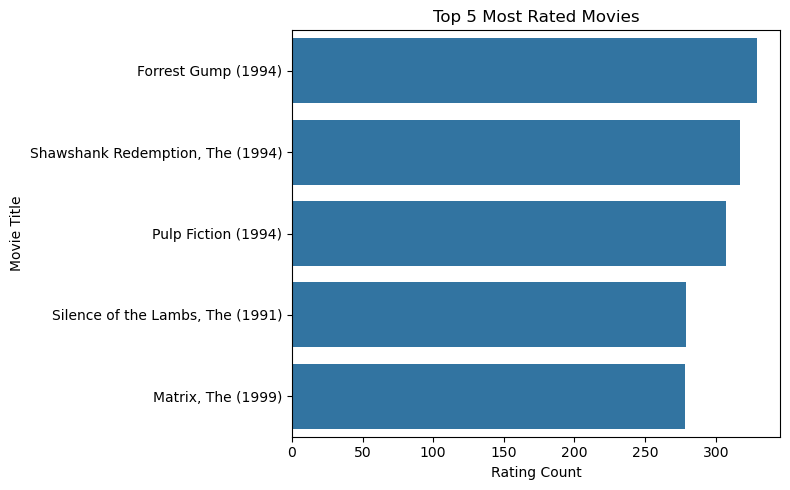

In [70]:
# Top 10 Most Rated Movies
plt.figure(figsize=(8,5))
sns.barplot(data=top_popular, x='rating_count', y='title')
plt.title("Top 5 Most Rated Movies")
plt.xlabel("Rating Count")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

In [71]:
# Build Genre-Based Similarity Model
count_vec = CountVectorizer(tokenizer=lambda x: x.split('|'), token_pattern=None)

def build_genre_model(df):
    genre_matrix = count_vec.fit_transform(df['genres'])
    
    model = NearestNeighbors(metric='cosine', algorithm='brute')
    model.fit(genre_matrix)
    
    return model, genre_matrix

In [72]:
#Converts movie genres like "Action|Adventure|Sci-Fi" into numerical vectors
#nn_model → the similarity search model
#genre_matrix → the numerical matrix of genre vectors

nn_model, genre_matrix = build_genre_model(df)

In [73]:
# Recommendation Function
def recommend_similar_movies(df, selected_title, model, genre_matrix, top_n=5):
    
    if selected_title not in df['title'].values:
        return f"❌ Movie '{selected_title}' not found in dataset."

    idx = df[df['title'] == selected_title].index[0]
    distances, indices = model.kneighbors(genre_matrix[idx], n_neighbors=top_n+10)

    similar_titles = df.iloc[indices[0]][['title', 'genres']]
    
    # Remove duplicates + remove the selected movie
    final = (
        similar_titles[similar_titles['title'] != selected_title]
        .drop_duplicates(subset='title')
        .head(top_n)
    )
    
    return final

In [74]:
# Example Recommendation
selected_movie = 'Forrest Gump (1994)'  
print(f"\nTop 5 movies similar to '{selected_movie}':")
print(recommend_similar_movies(df, selected_movie, nn_model, genre_matrix))


Top 5 movies similar to 'Forrest Gump (1994)':
                                            title                    genres
18554  Life Is Beautiful (La Vita è bella) (1997)  Comedy|Drama|Romance|War


In [75]:
selected_movie = 'Matrix, The (1999)'  
print(f"\nTop 5 movies similar to '{selected_movie}':")
print(recommend_similar_movies(df, selected_movie, nn_model, genre_matrix))


Top 5 movies similar to 'Matrix, The (1999)':
                        title                  genres
91826         Godzilla (1998)  Action|Sci-Fi|Thriller
57042  Terminator, The (1984)  Action|Sci-Fi|Thriller
51535      Equilibrium (2002)  Action|Sci-Fi|Thriller
99572     Blade Runner (1982)  Action|Sci-Fi|Thriller
74100         Predator (1987)  Action|Sci-Fi|Thriller


In [76]:
selected_movie = 'Forrest Gump (1994)'  
print(f"\nTop 5 movies similar to '{selected_movie}':")
print(recommend_similar_movies(df, selected_movie, nn_model, genre_matrix))


Top 5 movies similar to 'Forrest Gump (1994)':
                                            title                    genres
18554  Life Is Beautiful (La Vita è bella) (1997)  Comedy|Drama|Romance|War


In [77]:
import streamlit as st
import pickle #save the model files so that Streamlit can load them

In [78]:
pickle.dump(df.to_dict(), open('movies_dict.pkl','wb'))
pickle.dump(nn_model, open('model.pkl','wb'))
pickle.dump(genre_matrix, open('genre_matrix.pkl','wb'))